In [2]:
from __future__ import print_function, division
import os
import argparse
import torch.nn as nn
from skimage import io
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from utils import *
from utils.KittiColormap import *
from pyntcloud import PyntCloud
import pandas as pd
from cv_bridge import CvBridge
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from datasets.data_io import get_transform, read_all_lines
from PIL import Image

## Load Data from rosbag

In [3]:
list_filename = "./filenames/DS_train.txt"
lines = read_all_lines(list_filename)
splits = [line.split() for line in lines]
left_filenames = [x[0] for x in splits]
right_filenames = [x[1] for x in splits]
disp_filenames = [x[2] for x in splits]

In [4]:
def load_image(filename):
    return Image.open(filename).convert('RGB')

def load_disp(filename):
    data = Image.open(filename)
    data = np.array(data, dtype=np.float32) / 256.
    return data

In [5]:
index = 112
datapath = "/home/chris/pl_ws/src/stereo_pl_nav/datasets/DS"
left_img = load_image(os.path.join(datapath, left_filenames[index]))
right_img = load_image(os.path.join(datapath, right_filenames[index]))
disparity = load_disp(os.path.join(datapath, disp_filenames[index]))

(400, 881, 3)


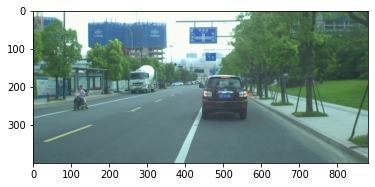

In [6]:
plt.imshow(left_img)
left_frame = np.asarray(left_img)
left_depth_rgb = left_frame[:, :, :3]
print(np.asarray(left_img).shape)

(400, 881)


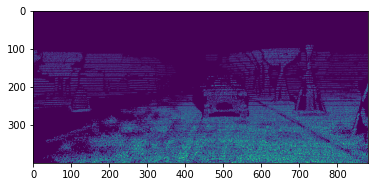

In [7]:
plt.imshow(disparity)
print(disparity.shape)

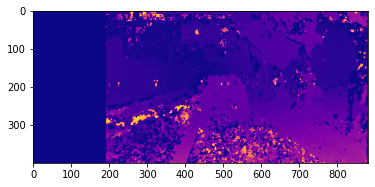

In [8]:
stereo = cv2.StereoSGBM_create(numDisparities=192, blockSize=11)
sgbm_disparity = stereo.compute(cv2.cvtColor(np.asarray(left_img), cv2.COLOR_BGR2GRAY),cv2.cvtColor(np.asarray(right_img), cv2.COLOR_BGR2GRAY))
plt.imshow(sgbm_disparity,'plasma')

In [9]:
w, h = left_img.size
crop_w, crop_h = 880, 400

left_img = left_img.crop((w - crop_w, h - crop_h, w, h))
right_img = right_img.crop((w - crop_w, h - crop_h, w, h))
disparity = disparity[h - crop_h:h, w - crop_w: w]

depth_rgb = np.transpose(np.asarray(left_img)[:, :, :3], (2, 0, 1))
print(depth_rgb.shape)

processed = get_transform()
left_img = processed(left_img)
right_img = processed(right_img)

(3, 400, 880)


(400, 880)

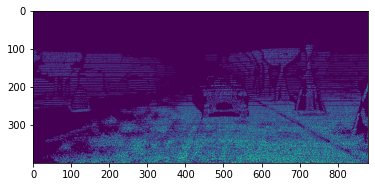

In [10]:
plt.imshow(disparity)
disparity.shape

In [11]:
from models.mobilestereonet.models.MSNet2D import MSNet2D
model = MSNet2D(192)
model = nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): MSNet2D(
    (feature_extraction): feature_extraction(
      (firstconv): Sequential(
        (0): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(9, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=9, bias=False)
            (4): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU6(inplace=True)
            (6): Conv2d(9, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ReLU(inplace=True)
        (2): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [12]:
ckpt_path = "/home/chris/pl_ws/src/stereo_pl_nav/scripts/models/MSNet2D_SF_DS_KITTI2015.ckpt"
print("Loading model {}".format(ckpt_path))
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict['model'])

Loading model /home/chris/pl_ws/src/stereo_pl_nav/scripts/models/MSNet2D_SF_DS_KITTI2015.ckpt


<All keys matched successfully>

In [13]:
# Camera intrinsics and extrinsics
c_u = 4.556890e+2
c_v = 1.976634e+2
f_u = 1.003556e+3
f_v = 1.003556e+3
b_x = 0.0
b_y = 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


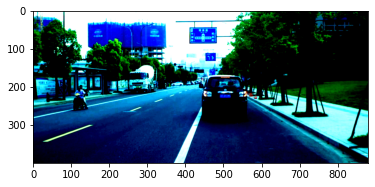

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


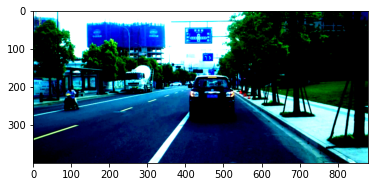

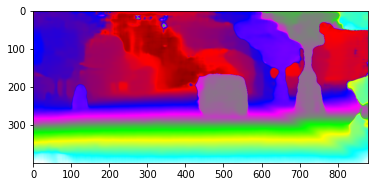

In [14]:
import matplotlib.pyplot as plt

model.eval()
plt.imshow(np.transpose(left_img, (1,2,0)))
plt.show()
plt.imshow(np.transpose(right_img, (1,2,0)))
plt.show()

sample_left = torch.Tensor(left_img)
sample_right = torch.Tensor(right_img)

sample_left = torch.unsqueeze(sample_left, dim=0)
sample_right = torch.unsqueeze(sample_right, dim=0)

with torch.no_grad():
    disp_est_tn = model(sample_left.cuda(), sample_right.cuda())[0]
    disp_est_np = tensor2numpy(disp_est_tn)
    disp_est = np.array(disp_est_np[0], dtype=np.float32)
    plt.imshow(kitti_colormap(disp_est))
    plt.show()
    disp_est[disp_est < 0] = 0
    baseline = 0.54

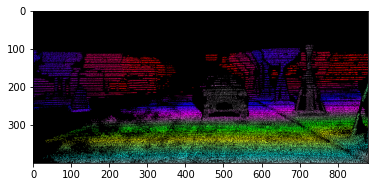

In [15]:
plt.imshow(kitti_colormap(disparity))

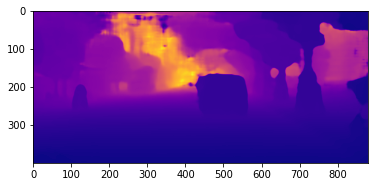

In [16]:
mask = disp_est > 0
depth = f_u * baseline / (disp_est + 1. - mask)
plt.imshow(depth, cmap="plasma")
plt.show()

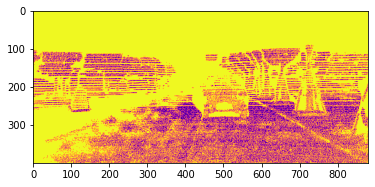

In [17]:
mask = disparity > 0
depth_gt = f_u * baseline / (disparity + 1. - mask)
plt.imshow(depth_gt, cmap="plasma")
plt.show()

In [18]:
def project_image_to_rect(uv_depth):
    ''' Input: nx3 first two channels are uv, 3rd channel
               is depth in rect camera coord.
        Output: nx3 points in rect camera coord.
    '''
    n = uv_depth.shape[0]
    x = ((uv_depth[:, 0] - c_u) * uv_depth[:, 2]) / f_u + b_x
    y = ((uv_depth[:, 1] - c_v) * uv_depth[:, 2]) / f_v + b_y
    pts_3d_rect = np.zeros((n, 3))
    pts_3d_rect[:, 0] = x
    pts_3d_rect[:, 1] = y
    pts_3d_rect[:, 2] = uv_depth[:, 2]
    return pts_3d_rect

def project_image_to_velo(uv_depth):
    pts_3d_rect = project_image_to_rect(uv_depth)
    return pts_3d_rect

mask = disp_est > 0
rows, cols = depth.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud = project_image_to_velo(points)

mask = disparity > 0
rows, cols = depth_gt.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth_gt])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud_gt = project_image_to_velo(points)


points_rgb = depth_rgb.reshape((3, -1)).T
points_rgb = points_rgb.astype(float)
points_rgb /= 255.

In [19]:
cloud_gt.shape

(66941, 3)

In [20]:
cloud.shape

(352000, 3)

In [21]:
points_rgb.shape

(352000, 3)

In [28]:
import open3d as o3d

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
rgbd_pcd = o3d.geometry.PointCloud()
rgbd_pcd.points = o3d.utility.Vector3dVector(cloud)
rgbd_pcd.colors = o3d.utility.Vector3dVector(points_rgb)

gt_pcd = o3d.geometry.PointCloud()
gt_pcd.points = o3d.utility.Vector3dVector(cloud_gt)

o3d.visualization.draw_geometries([rgbd_pcd, gt_pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
unit_np_pcd = o3d.geometry.PointCloud()
unit_np_pcd.points = o3d.utility.Vector3dVector(np.array([[0.0, -2.0, 0.0],[0.0, 0.0, 0.0],[0.0, 4.0, 0.0]]))
unit_np_pcd.paint_uniform_color([0.0, 0.0, 1.0])
o3d.visualization.draw_geometries([rgbd_pcd, unit_np_pcd])

In [ ]:
rgbd_voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(rgbd_pcd,
                                                            voxel_size=0.5)

In [ ]:
cloud.shape

In [ ]:
rgbd_voxel_grid

In [ ]:
rgbd_voxel_grid.get_min_bound()

In [ ]:
rgbd_voxel_grid.get_max_bound()

In [22]:
min_mask = cloud >= [-16,-31,0.0]
max_mask = cloud <= [16,1,32]
min_mask = min_mask[:, 0] & min_mask[:, 1] & min_mask[:, 2]
max_mask = max_mask[:, 0] & max_mask[:, 1] & max_mask[:, 2]
filter_mask = min_mask & max_mask
filtered_cloud = cloud[filter_mask]
print(filtered_cloud.shape)

(95430, 3)


In [23]:
min_mask = cloud_gt >= [-16,-31,0.0]
max_mask = cloud_gt <= [16,1,32]
min_mask = min_mask[:, 0] & min_mask[:, 1] & min_mask[:, 2]
max_mask = max_mask[:, 0] & max_mask[:, 1] & max_mask[:, 2]
filter_mask = min_mask & max_mask
filtered_cloud_gt = cloud_gt[filter_mask]
print(filtered_cloud_gt.shape)

(7707, 3)


In [24]:
voxel_size = 0.5 
xyz_q = np.floor(np.array(filtered_cloud/voxel_size)).astype(int) # quantized point values, here you will loose precision
vox_grid = torch.zeros((int(32/voxel_size), int(32/voxel_size), int(32/voxel_size))) #Empty voxel grid

offsets = np.array([32, 62, 0])
xyz_offset_q = xyz_q+offsets

vox_grid[xyz_offset_q[:,0],xyz_offset_q[:,1],xyz_offset_q[:,2]] = 1 # Setting all voxels containitn a points equal to 1
xyz_v = np.asarray(np.where(vox_grid == 1)) # get back indexes of populated voxels
empty_xyz_v = np.asarray(np.where(vox_grid == 0))

In [25]:
voxel_size = 0.5 
xyz_q_gt = np.floor(np.array(filtered_cloud_gt/voxel_size)).astype(int) # quantized point values, here you will loose precision
vox_grid_gt = torch.zeros((int(32/voxel_size), int(32/voxel_size), int(32/voxel_size))) #Empty voxel grid

offsets_gt = np.array([32, 62, 0])
xyz_offset_q_gt = xyz_q_gt+offsets_gt

vox_grid_gt[xyz_offset_q_gt[:,0],xyz_offset_q_gt[:,1],xyz_offset_q_gt[:,2]] = 1 # Setting all voxels containitn a points equal to 1
xyz_v_gt = np.asarray(np.where(vox_grid_gt == 1)) # get back indexes of populated voxels
empty_xyz_v_gt = np.asarray(np.where(vox_grid_gt == 0))

In [26]:
cloud_np = np.asarray([(pt-offsets)*voxel_size for pt in xyz_v.T])
empty_cloud_np = np.asarray([(pt-offsets)*voxel_size for pt in empty_xyz_v.T])

cloud_np_gt = np.asarray([(pt-offsets_gt)*voxel_size for pt in xyz_v_gt.T])

In [29]:
np_pcd = o3d.geometry.PointCloud()
np_pcd.points = o3d.utility.Vector3dVector(cloud_np)
np_pcd.paint_uniform_color([0.7, 0, 0])

np_pcd_gt = o3d.geometry.PointCloud()
np_pcd_gt.points = o3d.utility.Vector3dVector(cloud_np_gt)
np_pcd_gt.paint_uniform_color([0.0, 0.7, 0])

empty_np_pcd = o3d.geometry.PointCloud()
empty_np_pcd.points = o3d.utility.Vector3dVector(empty_cloud_np)
empty_np_pcd.paint_uniform_color([0.0, 0.7, 0])

PointCloud with 259402 points.

In [30]:
o3d.visualization.draw_geometries([rgbd_pcd, np_pcd, np_pcd_gt])

In [31]:
intersect = vox_grid*vox_grid_gt  # Logical AND
union = vox_grid+vox_grid_gt  # Logical OR

IoU = intersect.sum()/float(union.sum())
print(IoU)

tensor(0.0771)


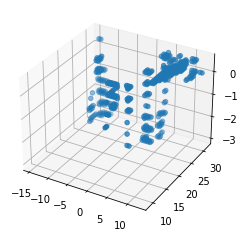

In [32]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cloud_np_gt[:,0],cloud_np_gt[:,2],cloud_np_gt[:,1],marker="o")
# ax.scatter(cloud_np[:,0],cloud_np[:,1],cloud_np[:,2],marker="^")

In [33]:
from pytorch3d.loss import chamfer_distance

In [39]:
chamfer_distance(torch.Tensor(np.expand_dims(cloud_np,0)), torch.Tensor(np.expand_dims(cloud_np_gt,0)))

(tensor(7.2268), None)